请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [1]:
#定义文件解压函数
import zipfile
import os
def unzip(source_file, target_dir):
    # source_file为待解压的文件路径，以zip文件结尾，如data/dataname.zip
    # target_dir为一个目录，存放解压后的文件，以“/”结尾，如data/
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)
    zf = zipfile.ZipFile(source_file)
    try:
        zf.extractall(path=target_dir)
    except RuntimeError as e:
        print(e)
    zf.close()
    print('---原始数据文件解压完成')

In [2]:
#进行文件解压
#unzip('/home/aistudio/data/data100461/valid_gt.zip','data/data_unzip/')
#unzip('/home/aistudio/data/data100461/training.zip','data/data_unzip/')
#unzip('/home/aistudio/data/data100461/validation.zip','data/data_unzip/')

In [3]:
#unzip('/home/aistudio/data/data_unzip/PALM-Training400/PALM-Training400.zip','data/datatrain_unzip/')

In [4]:
#iChallenge-PM中既有病理性近视患者的眼底图片，也有非病理性近视患者的图片，命名规则如下：
# - 病理性近视（PM）：文件名以P开头
# - 非病理性近视（non-PM）：
#   * 高度近视（high myopia）：文件名以H开头
#   * 正常眼睛（normal）：文件名以N开头 
# 我们将病理性患者的图片作为正样本，标签为1； 非病理性患者的图片作为负样本，标签为0。
#从数据集中选取两张图片，通过ResNet提取特征，构建分类器，对正负样本进行分类，并将图片显示出来。

In [5]:
#定义数据读取器
#使用OpenCV从磁盘读入图片，将每张图缩放到$224\times224$大小，并且将像素值调整到$[-1, 1]$之间，代码如下所示：
import cv2
import random
import numpy as np
import os

# 对读入的图像数据进行预处理
def transform_img(img):
    # 将图片尺寸缩放道 224x224
    img = cv2.resize(img, (224, 224))
    # 读入的图像数据格式是[H, W, C]
    # 使用转置操作将其变成[C, H, W]
    img = np.transpose(img, (2,0,1))
    img = img.astype('float32')
    # 将数据范围调整到[-1.0, 1.0]之间
    img = img / 255.
    img = img * 2.0 - 1.0
    return img

In [6]:
# 定义训练集数据读取器
def data_loader(datadir, batch_size=10, mode = 'train'):
    # 将datadir目录下的文件列出来，每条文件都要读入
    filenames = os.listdir(datadir)
    #print(filenames)
    def reader():
        if mode == 'train':
            # 训练时随机打乱数据顺序
            random.shuffle(filenames)
        batch_imgs = []
        batch_labels = []
        for name in filenames:
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            if name[0] == 'H' or name[0] == 'N':
                # H开头的文件名表示高度近似，N开头的文件名表示正常视力
                # 高度近视和正常视力的样本，都不是病理性的，属于负样本，标签为0
                label = 0
            elif name[0] == 'P':
                # P开头的是病理性近视，属于正样本，标签为1
                label = 1
            else:
                raise('Not excepted file name')
            # 每读取一个样本的数据，就将其放入数据列表中
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                # 当数据列表的长度等于batch_size的时候，
                # 把这些数据当作一个mini-batch，并作为数据生成器的一个输出
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            # 剩余样本数目不足一个batch_size的数据，一起打包成一个mini-batch
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
            yield imgs_array, labels_array

    return reader

In [7]:
# 定义验证集数据读取器
def valid_data_loader(datadir, csvfile, batch_size=10, mode='valid'):
    # 训练集读取时通过文件名来确定样本标签，验证集则通过csvfile来读取每个图片对应的标签
    # 请查看解压后的验证集标签数据，观察csvfile文件里面所包含的内容
    # csvfile文件所包含的内容格式如下，每一行代表一个样本，
    # 其中第一列是图片id，第二列是文件名，第三列是图片标签，
    # 第四列和第五列是Fovea的坐标，与分类任务无关
    # ID,imgName,Label,Fovea_X,Fovea_Y
    # 1,V0001.jpg,0,1157.74,1019.87
    # 2,V0002.jpg,1,1285.82,1080.47
    # 打开包含验证集标签的csvfile，并读入其中的内容
    filelists = open(csvfile).readlines()
    #print(filelists)
    def reader():
        batch_imgs = []
        batch_labels = []
        for line in filelists[1:-1]:
            line = line.strip().split(',')
            #print(line)
            name = line[1]
            #print(line[0])
            # label = ord(line[2])-48
            label = line[2]
            label = int(label)
            # 根据图片文件名加载图片，并对图像数据作预处理
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            # 每读取一个样本的数据，就将其放入数据列表中
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                # 当数据列表的长度等于batch_size的时候，
                # 把这些数据当作一个mini-batch，并作为数据生成器的一个输出
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            # 剩余样本数目不足一个batch_size的数据，一起打包成一个mini-batch
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
            yield imgs_array, labels_array

    return reader


In [8]:
# 识别眼疾图片
import os
import random
import paddle
import numpy as np
import matplotlib.pyplot as plt

DATADIR = './data/datatrain_unzip/PALM-Training400'
DATADIR2 = './data/data_unzip/PALM-Validation400'
CSVFILE = './data/data_unzip/labels.csv'

# 定义训练过程
def train_pm(model, optimizer):
    # 开启0号GPU训练
    #use_gpu = True
    #paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')

    print('start training ... ')
    model.train()
    epoch_num = 10
    # 定义数据读取器，训练数据读取器和验证数据读取器
    train_loader = data_loader(DATADIR, batch_size=10, mode='train')
    valid_loader = valid_data_loader(DATADIR2, CSVFILE)
    accuracies = []
    losses = []
    for epoch in range(epoch_num):
        for batch_id, data in enumerate(train_loader()):
            x_data, y_data = data
            img = paddle.to_tensor(x_data)
            label = paddle.to_tensor(y_data)
            # 运行模型前向计算，得到预测值
            logits = model(img)
            loss = F.binary_cross_entropy_with_logits(logits, label)
            avg_loss = paddle.mean(loss)

            # 反向传播，更新权重，清除梯度
            avg_loss.backward()
            optimizer.step()
            optimizer.clear_grad()

        model.eval()
        acc_mea = []
        loss_mea = []
        for batch_id, data in enumerate(valid_loader()):
            x_data, y_data = data
            img = paddle.to_tensor(x_data)
            label = paddle.to_tensor(y_data)
            # 运行模型前向计算，得到预测值
            logits = model(img)
            # 二分类，sigmoid计算后的结果以0.5为阈值分两个类别
            # 计算sigmoid后的预测概率，进行loss计算
            pred = F.sigmoid(logits)
            loss = F.binary_cross_entropy_with_logits(logits, label)
            # 计算预测概率小于0.5的类别
            pred2 = pred * (-1.0) + 1.0
            # 得到两个类别的预测概率，并沿第一个维度级联
            pred = paddle.concat([pred2, pred], axis=1)
            acc = paddle.metric.accuracy(pred, paddle.cast(label, dtype='int64'))

            acc_mea.append(acc.numpy())
            loss_mea.append(loss.numpy())
        print("epoch: {}, [validation] accuracy: {} / loss: {}".format(epoch, np.mean(acc_mea), np.mean(loss_mea)))
        model.train()

        accuracies.append(np.mean(acc_mea))
        losses.append(np.mean(loss_mea))

        paddle.save(model.state_dict(), 'palm.pdparams')
        paddle.save(optimizer.state_dict(), 'palm.pdopt')

    plt.plot(range(epoch_num), accuracies)
    plt.xlabel('epoch')
    plt.ylabel('accuracies')
    plt.figure()
    plt.plot(range(epoch_num), losses)
    plt.xlabel('epoch')
    plt.ylabel('losses')
    plt.show()


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [9]:
# 定义评估过程
def evaluation(model, params_file_path):

    # 开启0号GPU预估
    #use_gpu = True
    #paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')

    print('start evaluation .......')

    #加载模型参数
    model_state_dict = paddle.load(params_file_path)
    model.load_dict(model_state_dict)

    model.eval()
    eval_loader = data_loader(DATADIR, 
                        batch_size=10, mode='eval')

    acc_set = []
    avg_loss_set = []
    for batch_id, data in enumerate(eval_loader()):
        x_data, y_data = data
        img = paddle.to_tensor(x_data)
        label = paddle.to_tensor(y_data)
        y_data = y_data.astype(np.int64)
        label_64 = paddle.to_tensor(y_data)
        # 计算预测和精度
        prediction, acc = model(img, label_64)
        # 计算损失函数值
        loss = F.binary_cross_entropy_with_logits(prediction, label)
        avg_loss = paddle.mean(loss)
        acc_set.append(float(acc.numpy()))
        avg_loss_set.append(float(avg_loss.numpy()))
    # 求平均精度
    acc_val_mean = np.array(acc_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()

    print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))

In [10]:
# ResNet模型代码
import numpy as np
import paddle
import paddle.nn as nn
import paddle.nn.functional as F

# ResNet中使用了BatchNorm层，在卷积层的后面加上BatchNorm以提升数值稳定性
# 定义卷积批归一化块
class ConvBNLayer(paddle.nn.Layer):
    def __init__(self,
                 num_channels,
                 num_filters,
                 filter_size,
                 stride=1,
                 groups=1,
                 act=None):

        """
        num_channels, 卷积层的输入通道数
        num_filters, 卷积层的输出通道数
        stride, 卷积层的步幅
        groups, 分组卷积的组数，默认groups=1不使用分组卷积
        """
        super(ConvBNLayer, self).__init__()

        # 创建卷积层
        self._conv = nn.Conv2D(
            in_channels=num_channels,
            out_channels=num_filters,
            kernel_size=filter_size,
            stride=stride,
            padding=(filter_size - 1) // 2,
            groups=groups,
            bias_attr=False)

        # 创建BatchNorm层
        self._batch_norm = paddle.nn.BatchNorm2D(num_filters)

        self.act = act

    def forward(self, inputs):
        y = self._conv(inputs)
        y = self._batch_norm(y)
        if self.act == 'leaky':
            y = F.leaky_relu(x=y, negative_slope=0.1)
        elif self.act == 'relu':
            y = F.relu(x=y)
        return y


In [11]:
# 定义残差块
# 每个残差块会对输入图片做三次卷积，然后跟输入图片进行短接
# 如果残差块中第三次卷积输出特征图的形状与输入不一致，则对输入图片做1x1卷积，将其输出形状调整成一致
class BottleneckBlock(paddle.nn.Layer):
    def __init__(self,
                 num_channels,
                 num_filters,
                 stride,
                 shortcut=True):
        super(BottleneckBlock, self).__init__()
        # 创建第一个卷积层 1x1
        self.conv0 = ConvBNLayer(
            num_channels=num_channels,
            num_filters=num_filters,
            filter_size=1,
            act='relu')
        # 创建第二个卷积层 3x3
        self.conv1 = ConvBNLayer(
            num_channels=num_filters,
            num_filters=num_filters,
            filter_size=3,
            stride=stride,
            act='relu')
        # 创建第三个卷积 1x1，但输出通道数乘以4
        self.conv2 = ConvBNLayer(
            num_channels=num_filters,
            num_filters=num_filters * 4,
            filter_size=1,
            act=None)

        # 如果conv2的输出跟此残差块的输入数据形状一致，则shortcut=True
        # 否则shortcut = False，添加1个1x1的卷积作用在输入数据上，使其形状变成跟conv2一致
        if not shortcut:
            self.short = ConvBNLayer(
                num_channels=num_channels,
                num_filters=num_filters * 4,
                filter_size=1,
                stride=stride)

        self.shortcut = shortcut

        self._num_channels_out = num_filters * 4

    def forward(self, inputs):
        y = self.conv0(inputs)
        conv1 = self.conv1(y)
        conv2 = self.conv2(conv1)

        # 如果shortcut=True，直接将inputs跟conv2的输出相加
        # 否则需要对inputs进行一次卷积，将形状调整成跟conv2输出一致
        if self.shortcut:
            short = inputs
        else:
            short = self.short(inputs)

        y = paddle.add(x=short, y=conv2)
        y = F.relu(y)
        return y

In [12]:
# 定义ResNet模型
class ResNet(paddle.nn.Layer):
    def __init__(self, layers=50, class_dim=1):
        """
        
        layers, 网络层数，可以是50, 101或者152
        class_dim，分类标签的类别数
        """
        super(ResNet, self).__init__()
        self.layers = layers
        supported_layers = [50, 101, 152]
        assert layers in supported_layers,             "supported layers are {} but input layer is {}".format(supported_layers, layers)

        if layers == 50:
            #ResNet50包含多个模块，其中第2到第5个模块分别包含3、4、6、3个残差块
            depth = [3, 4, 6, 3]
        elif layers == 101:
            #ResNet101包含多个模块，其中第2到第5个模块分别包含3、4、23、3个残差块
            depth = [3, 4, 23, 3]
        elif layers == 152:
            #ResNet152包含多个模块，其中第2到第5个模块分别包含3、8、36、3个残差块
            depth = [3, 8, 36, 3]

        # 残差块中使用到的卷积的输出通道数
        num_filters = [64, 128, 256, 512]

        # ResNet的第一个模块，包含1个7x7卷积，后面跟着1个最大池化层
        self.conv = ConvBNLayer(
            num_channels=3,
            num_filters=64,
            filter_size=7,
            stride=2,
            act='relu')
        self.pool2d_max = nn.MaxPool2D(
            kernel_size=3,
            stride=2,
            padding=1)

        # ResNet的第二到第五个模块c2、c3、c4、c5
        self.bottleneck_block_list = []
        num_channels = 64
        for block in range(len(depth)):
            shortcut = False
            for i in range(depth[block]):
                bottleneck_block = self.add_sublayer(
                    'bb_%d_%d' % (block, i),
                    BottleneckBlock(
                        num_channels=num_channels,
                        num_filters=num_filters[block],
                        stride=2 if i == 0 and block != 0 else 1, # c3、c4、c5将会在第一个残差块使用stride=2；其余所有残差块stride=1
                        shortcut=shortcut))
                num_channels = bottleneck_block._num_channels_out
                self.bottleneck_block_list.append(bottleneck_block)
                shortcut = True

        # 在c5的输出特征图上使用全局池化
        self.pool2d_avg = paddle.nn.AdaptiveAvgPool2D(output_size=1)

        # stdv用来作为全连接层随机初始化参数的方差
        import math
        stdv = 1.0 / math.sqrt(2048 * 1.0)

        # 创建全连接层，输出大小为类别数目，经过残差网络的卷积和全局池化后，
        # 卷积特征的维度是[B,2048,1,1]，故最后一层全连接的输入维度是2048
        self.out = nn.Linear(in_features=2048, out_features=class_dim,
                      weight_attr=paddle.ParamAttr(
                          initializer=paddle.nn.initializer.Uniform(-stdv, stdv)))

    def forward(self, inputs):
        y = self.conv(inputs)
        y = self.pool2d_max(y)
        for bottleneck_block in self.bottleneck_block_list:
            y = bottleneck_block(y)
        y = self.pool2d_avg(y)
        y = paddle.reshape(y, [y.shape[0], -1])
        y = self.out(y)
        return y

start training ... 


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


epoch: 0, [validation] accuracy: 0.737500011920929 / loss: 0.5892349481582642
epoch: 1, [validation] accuracy: 0.9350000619888306 / loss: 0.30784597992897034
epoch: 2, [validation] accuracy: 0.6150000095367432 / loss: 1.4851183891296387
epoch: 3, [validation] accuracy: 0.9475000500679016 / loss: 0.1758701503276825
epoch: 4, [validation] accuracy: 0.949999988079071 / loss: 0.18256983160972595
epoch: 5, [validation] accuracy: 0.9550000429153442 / loss: 0.15785668790340424
epoch: 6, [validation] accuracy: 0.9475000500679016 / loss: 0.16567867994308472
epoch: 7, [validation] accuracy: 0.949999988079071 / loss: 0.1496039628982544
epoch: 8, [validation] accuracy: 0.9574999809265137 / loss: 0.13880400359630585
epoch: 9, [validation] accuracy: 0.9600000381469727 / loss: 0.17298109829425812


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


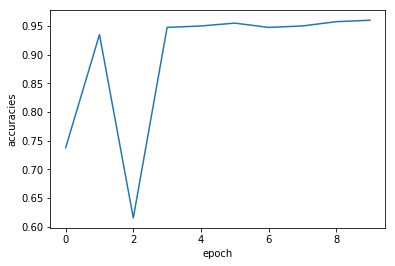

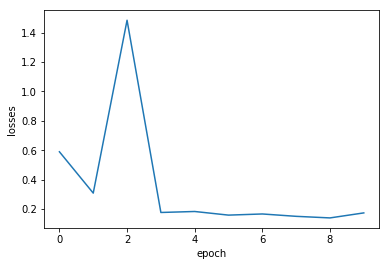

In [13]:
# 创建模型
model = ResNet()
# 定义优化器
opt = paddle.optimizer.Momentum(learning_rate=0.001, momentum=0.9, parameters=model.parameters(), weight_decay=0.001)
# 启动训练过程
train_pm(model, opt)


# 通过运行结果可以发现，使用ResNet在眼疾筛查数据集iChallenge-PM上，loss能有效的下降，经过5个epoch的训练，在验证集上的准确率可以达到95%左右。

epoch: 0, [validation] accuracy: 0.5275000333786011 / loss: 1.3340431451797485
epoch: 1, [validation] accuracy: 0.9099999666213989 / loss: 0.28420910239219666
epoch: 2, [validation] accuracy: 0.9274999499320984 / loss: 0.22786939144134521
epoch: 3, [validation] accuracy: 0.9450000524520874 / loss: 0.21456265449523926
epoch: 4, [validation] accuracy: 0.925000011920929 / loss: 0.2556702196598053
epoch: 5, [validation] accuracy: 0.9325000047683716 / loss: 0.19270552694797516
epoch: 6, [validation] accuracy: 0.9424999952316284 / loss: 0.2056727409362793
epoch: 7, [validation] accuracy: 0.9225000143051147 / loss: 0.2161128968000412
epoch: 8, [validation] accuracy: 0.925000011920929 / loss: 0.2870018482208252
epoch: 9, [validation] accuracy: 0.8774999380111694 / loss: 0.3954811096191406